In [1]:
import pandas as pd
import matplotlib.pyplot as pl
from keras.preprocessing.text import one_hot
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)




Using TensorFlow backend.


In [2]:
df_main=pd.read_json('train-v2.0.json')

In [3]:
df_main.head()

,version,data
0,v2.0,"{'title': 'Beyoncé', 'paragraphs': [{'qas': [{..."
1,v2.0,"{'title': 'Frédéric_Chopin', 'paragraphs': [{'..."
2,v2.0,{'title': 'Sino-Tibetan_relations_during_the_M...
3,v2.0,"{'title': 'IPod', 'paragraphs': [{'qas': [{'qu..."
4,v2.0,{'title': 'The_Legend_of_Zelda:_Twilight_Princ...


In [4]:
df_main.shape

(442, 2)

In [5]:
temp=df_main['data'][0]

In [6]:
par=temp['paragraphs']

In [7]:
ques=par[0]['qas']
ques[0]

{'question': 'When did Beyonce start becoming popular?',
 'id': '56be85543aeaaa14008c9063',
 'answers': [{'text': 'in the late 1990s', 'answer_start': 269}],
 'is_impossible': False}

In [8]:
title=[]
questions=[]
answers=[]
answer_start=[]
is_answerable=[]

In [9]:
for sample in df_main['data']:
    pars=sample['paragraphs']
    for par in pars:
        ques=par['qas']
        for i in ques:
            questions.append(i['question'])
            if i['answers']:
                answers.append(i['answers'][0]['text'])
                answer_start.append(i['answers'][0]['answer_start'])
            else:
                answers.append('Null')
                answer_start.append('Null')
            is_answerable.append(i['is_impossible'])

In [10]:
len(questions),len(answers),len(answer_start),len(is_answerable)

(130319, 130319, 130319, 130319)

In [11]:
df=pd.DataFrame({'Question':questions,
                 'Answers':answers,
                 'Answer_start':answer_start,
                 'Is_answerable':is_answerable
                })

In [12]:
df.head(10)

,Question,Answers,Answer_start,Is_answerable
0,When did Beyonce start becoming popular?,in the late 1990s,269,False
1,What areas did Beyonce compete in when she was...,singing and dancing,207,False
2,When did Beyonce leave Destiny's Child and bec...,2003,526,False
3,In what city and state did Beyonce grow up?,"Houston, Texas",166,False
4,In which decade did Beyonce become famous?,late 1990s,276,False
5,In what R&B group was she the lead singer?,Destiny's Child,320,False
6,What album made her a worldwide known artist?,Dangerously in Love,505,False
7,Who managed the Destiny's Child group?,Mathew Knowles,360,False
8,When did Beyoncé rise to fame?,late 1990s,276,False
9,What role did Beyoncé have in Destiny's Child?,lead singer,290,False


In [13]:
dev_data=pd.read_json('dev-v2.0.json')

In [14]:
questions=[]
answers=[]
answer_start=[]
is_answerable=[]
for sample in dev_data['data']:
    pars=sample['paragraphs']
    for par in pars:
        ques=par['qas']
        for i in ques:
            questions.append(i['question'])
            if i['answers']:
                answers.append(i['answers'][0]['text'])
                answer_start.append(i['answers'][0]['answer_start'])
            else:
                answers.append('Null')
                answer_start.append('Null')
            is_answerable.append(i['is_impossible'])
dev_df=pd.DataFrame({'Question':questions,
                 'Answers':answers,
                 'Answer_start':answer_start,
                 'Is_answerable':is_answerable
                })

In [15]:
dev_df

,Question,Answers,Answer_start,Is_answerable
0,In what country is Normandy located?,France,159,False
1,When were the Normans in Normandy?,10th and 11th centuries,94,False
2,From which countries did the Norse originate?,"Denmark, Iceland and Norway",256,False
3,Who was the Norse leader?,Rollo,308,False
4,What century did the Normans first gain their ...,10th century,671,False
...,...,...,...,...
11868,What is the seldom used force unit equal to on...,sthène,665,False
11869,What does not have a metric counterpart?,Null,Null,True
11870,What is the force exerted by standard gravity ...,Null,Null,True
11871,What force leads to a commonly used unit of mass?,Null,Null,True


<IPython.core.display.Javascript object>

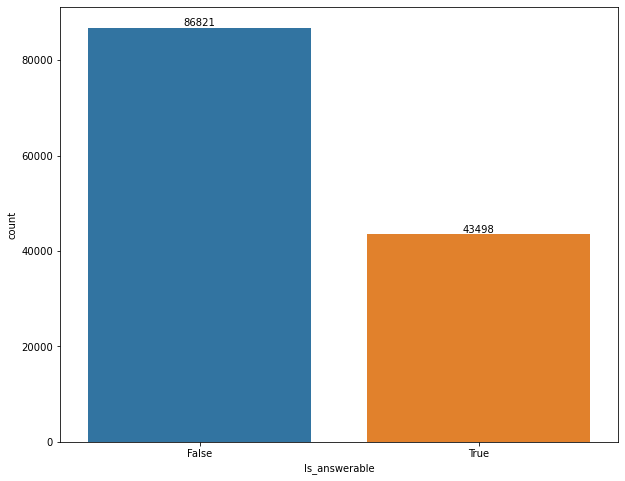

In [16]:
pl.figure(figsize=(10,8))

ax=sns.countplot(df['Is_answerable'])
rects=ax.patches

for rect in rects:
    height=rect.get_height()
    ax.text(x=rect.get_x()+rect.get_width()/2,y=height+5,s=height,ha='center',va='bottom')
pl.show()

<IPython.core.display.Javascript object>

-0.4 0.8
0.6 0.8


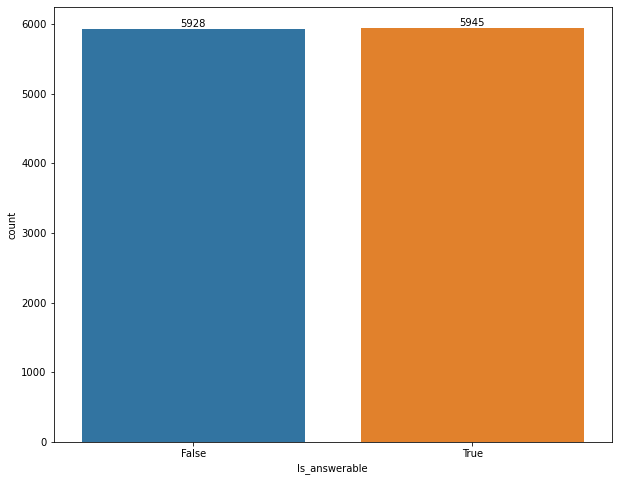

In [17]:
pl.figure(figsize=(10,8))

ax=sns.countplot(dev_df['Is_answerable'])
rects=ax.patches
for rect in rects:
    height=rect.get_height()
    print(rect.get_x(),rect.get_width())
    ax.text(x=rect.get_x()+rect.get_width()/2,y=height+1,s=height,ha='center',va='bottom')
pl.show()

In [18]:
len(df),df['Answer_start'].nunique()

(130319, 1604)

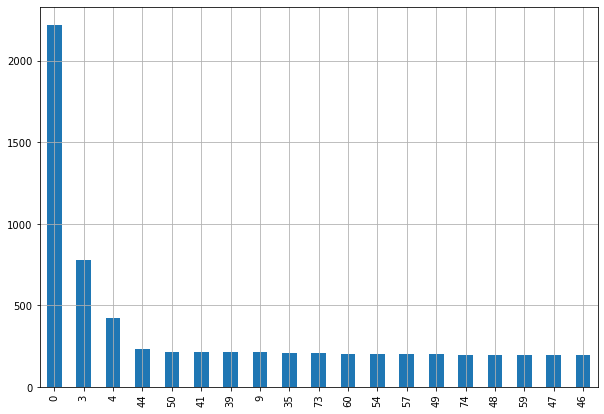

In [19]:
df['Answer_start'].value_counts()[1:20].plot(kind='bar',figsize=(10,7))
pl.grid()
pl.show()

In [23]:
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

In [24]:
df['len_que']=df['Question'].apply(lambda x: len(x))
df['len_ans']=df['Answers'].apply(lambda x: len(x))

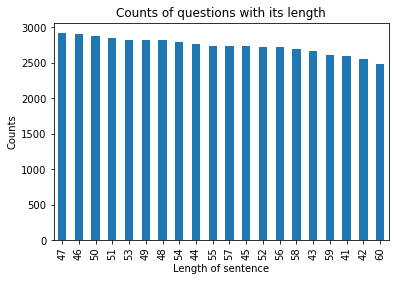

In [25]:
df['len_que'].value_counts()[:20].plot.bar()
pl.title('Counts of questions with its length')
pl.xlabel('Length of sentence')
pl.ylabel('Counts')
pl.show()

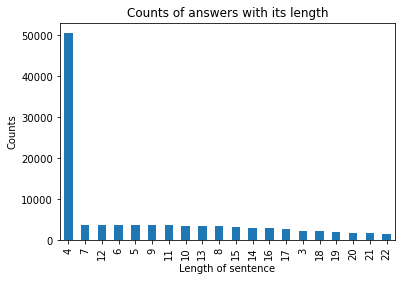

In [26]:
df['len_ans'].value_counts()[:20].plot.bar()
pl.title('Counts of answers with its length')
pl.xlabel('Length of sentence')
pl.ylabel('Counts')
pl.show()

In [27]:
df.describe()

,len_que,len_ans
count,130319.000000,130319.000000
mean,58.507739,14.758884
std,73.757111,19.193666
min,1.000000,1.000000
25%,44.000000,4.000000
50%,55.000000,7.000000
75%,69.000000,17.000000
max,25651.000000,239.000000


In [28]:
df.drop(107709,axis=0,inplace=True)

In [29]:
df.reset_index(drop=True,inplace=True)

In [30]:
df.head()

,Question,Answers,Answer_start,Is_answerable,len_que,len_ans
0,When did Beyonce start becoming popular?,in the late 1990s,269,False,40,17
1,What areas did Beyonce compete in when she was...,singing and dancing,207,False,58,19
2,When did Beyonce leave Destiny's Child and bec...,2003,526,False,64,4
3,In what city and state did Beyonce grow up?,"Houston, Texas",166,False,45,14
4,In which decade did Beyonce become famous?,late 1990s,276,False,42,10


In [31]:
len(df)

130318

In [43]:
df=df.sort_values('len_que',ascending=False)[5000:].copy()

In [50]:
df_s=df.sample(10000).copy()

In [51]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

In [52]:
for line,t in zip(df_s['Question'],df_s['Answers']):
    input_texts.append(line)
    target_texts.append(t)
    for char in line:
        if char not in input_characters:
            input_characters.add(char)
    for char in t:
        if char not in target_characters:
            target_characters.add(char)

In [53]:
print(input_characters)

{'/', '=', '⟨', 'd', 'V', 'T', 'Z', 'n', '3', 'W', '4', '6', 'l', 'H', '0', 'u', '1', '(', 'ü', 'θ', '❤', 'ź', 'h', '9', 'z', 'ā', '>', '$', 't', 'M', 'ī', 'w', 'x', 'E', ' ', 'Q', 'S', '5', 'v', 'a', 'j', 'i', 'ö', '+', 'N', 'ò', 'á', 'ѣ', 'ı', '−', 'q', "'", 'ḥ', 'é', ')', 'o', 'ó', 'O', '2', 'c', 'ć', '°', 'ð', '?', '.', 'X', 'R', 'k', '⟩', '!', '%', 'f', 'ñ', 'L', 'B', 'I', '*', 'P', 'í', 'Y', '7', 'J', 'U', 'Ḥ', 'm', 'b', 'C', ':', 'p', '-', ';', '_', 'F', 'y', '&', 's', ',', 'G', 'K', 'É', 'D', '"', 'e', '#', '8', 'r', 'g', 'A', '–'}


In [54]:
print(target_characters)

{'/', '⟨', '€', 'd', 'V', 'T', 'ô', 'Z', 'n', '3', 'ج', '4', 'W', 'ë', 'ß', '[', 'τ', 'έ', 'ʾ', '6', 'ç', 'l', 'H', '£', '0', 'ع', 'u', '1', 'Ḍ', 'ư', '(', 'ü', 'ś', 'h', '9', 'z', 'ā', 'ə', 'κ', '$', 't', 'ú', 'M', 'ν', 'ī', 'w', 'ę', 'x', 'E', ' ', '”', 'χ', '“', 'Q', 'S', '5', 'v', 'a', 'ˈ', 'j', 'i', 'è', 'ö', '+', 'N', 'ō', 'Ü', 'á', 'š', 'Ö', 'ι', '−', 'ã', 'q', "'", '—', ']', ')', 'é', 'o', 'ó', 'O', '2', 'c', 'ć', '°', '?', '.', 'ū', 'X', 'R', 'k', '⟩', 'ʻ', '!', '%', 'ω', 'f', '’', 'ñ', 'е', 'س', 'L', 'ż', 'B', 'I', 'P', 'í', 'Y', '7', 'J', 'U', 'b', 'm', 'â', 'ρ', 'C', 'ṣ', 'ɪ', ':', 'ä', '-', 'p', '₹', 'ἀ', ';', '×', 'F', 'ł', 'y', '&', 's', ',', 'G', 'K', 'ɒ', 'D', '"', 'e', '#', '8', 'ṃ', 'r', 'ï', 'g', 'ń', 'A', '–'}


In [55]:
input_characters=sorted(list(input_characters))
target_characters=sorted(list(target_characters))
num_encoder_tokens=len(input_characters)
num_decoder_tokens=len(target_characters)
max_encoder_len=max([len(txt) for txt in input_texts])
max_decoder_len=max([len(txt) for txt in target_texts])


print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_len)
print('Max sequence length for outputs:', max_decoder_len)

Number of samples: 10000
Number of unique input tokens: 109
Number of unique output tokens: 148
Max sequence length for inputs: 100
Max sequence length for outputs: 160


In [58]:
input_token_index=dict([(char,i) for i,char in enumerate(input_characters)])
target_token_index=dict([(char,i) for i,char in enumerate(target_characters)])

In [60]:
print(input_token_index)

{' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, '&': 6, "'": 7, '(': 8, ')': 9, '*': 10, '+': 11, ',': 12, '-': 13, '.': 14, '/': 15, '0': 16, '1': 17, '2': 18, '3': 19, '4': 20, '5': 21, '6': 22, '7': 23, '8': 24, '9': 25, ':': 26, ';': 27, '=': 28, '>': 29, '?': 30, 'A': 31, 'B': 32, 'C': 33, 'D': 34, 'E': 35, 'F': 36, 'G': 37, 'H': 38, 'I': 39, 'J': 40, 'K': 41, 'L': 42, 'M': 43, 'N': 44, 'O': 45, 'P': 46, 'Q': 47, 'R': 48, 'S': 49, 'T': 50, 'U': 51, 'V': 52, 'W': 53, 'X': 54, 'Y': 55, 'Z': 56, '_': 57, 'a': 58, 'b': 59, 'c': 60, 'd': 61, 'e': 62, 'f': 63, 'g': 64, 'h': 65, 'i': 66, 'j': 67, 'k': 68, 'l': 69, 'm': 70, 'n': 71, 'o': 72, 'p': 73, 'q': 74, 'r': 75, 's': 76, 't': 77, 'u': 78, 'v': 79, 'w': 80, 'x': 81, 'y': 82, 'z': 83, '°': 84, 'É': 85, 'á': 86, 'é': 87, 'í': 88, 'ð': 89, 'ñ': 90, 'ò': 91, 'ó': 92, 'ö': 93, 'ü': 94, 'ā': 95, 'ć': 96, 'ī': 97, 'ı': 98, 'ź': 99, 'θ': 100, 'ѣ': 101, 'Ḥ': 102, 'ḥ': 103, '–': 104, '−': 105, '❤': 106, '⟨': 107, '⟩': 108}


In [61]:
print(target_token_index)

{' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, '&': 6, "'": 7, '(': 8, ')': 9, '+': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '?': 27, 'A': 28, 'B': 29, 'C': 30, 'D': 31, 'E': 32, 'F': 33, 'G': 34, 'H': 35, 'I': 36, 'J': 37, 'K': 38, 'L': 39, 'M': 40, 'N': 41, 'O': 42, 'P': 43, 'Q': 44, 'R': 45, 'S': 46, 'T': 47, 'U': 48, 'V': 49, 'W': 50, 'X': 51, 'Y': 52, 'Z': 53, '[': 54, ']': 55, 'a': 56, 'b': 57, 'c': 58, 'd': 59, 'e': 60, 'f': 61, 'g': 62, 'h': 63, 'i': 64, 'j': 65, 'k': 66, 'l': 67, 'm': 68, 'n': 69, 'o': 70, 'p': 71, 'q': 72, 'r': 73, 's': 74, 't': 75, 'u': 76, 'v': 77, 'w': 78, 'x': 79, 'y': 80, 'z': 81, '£': 82, '°': 83, 'Ö': 84, '×': 85, 'Ü': 86, 'ß': 87, 'á': 88, 'â': 89, 'ã': 90, 'ä': 91, 'ç': 92, 'è': 93, 'é': 94, 'ë': 95, 'í': 96, 'ï': 97, 'ñ': 98, 'ó': 99, 'ô': 100, 'ö': 101, 'ú': 102, 'ü': 103, 'ā': 104, 'ć': 105, 'ę': 106, 'ī': 107, 'ł': 108, 'ń': 109, 'ō': 110,

In [78]:
import numpy as np
encoder_input_data=np.zeros(
    (len(input_texts),max_encoder_len,num_encoder_tokens),
    dtype='float32'
)
decoder_input_data=np.zeros(
    (len(target_texts),max_decoder_len,num_decoder_tokens),
    dtype='float32'
)
decoder_target_data = np.zeros(
  (len(input_texts), max_decoder_len, num_decoder_tokens),
  dtype='float32')

In [79]:
encoder_input_data.shape,decoder_input_data.shape

((10000, 100, 109), (10000, 160, 148))

In [95]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    print(input_text)
    print()
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
    # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
          # decoder_target_data will be ahead by one timestep
          # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

What was the event called that caused  Ayutthaya  to reclaim lost territories ?

What was done to have the privilege of working on an SNES for repair?

What nationality was Alcmaeon of Croton?

Where were lateral cut disc records developed?

Dogs can digest meat as well as what else?

What is another term for anti-aircraft warfare?

What must an infectious agent not be identified in to satisfy the first of Koch's postulates?

How did Kuhn view the history of science?

What country does not have an independent judiciary?

What feature was missing from the final Mac design produced by Smith?

What deities were on the edge of Roman religious community? 

What does the term "pardo" include?

During what stage can starch sources be added at more than one point?

What did Senator H.R. Heinrich's bill require?

What were the minor advantages of the tantalum light filament from Siemens?

When did the military operation end in Rasht Valley?

When was the first figure skating championship held? 


Who was the first female to be saved by the judges on American Idol?

Serious studies in logic tend to resemble what discipline, moreso than literature?

What was the new name of the French Armed Forces?

With what did the college boy's hit the shooter with?

What state opened the first public university in the United States?

What aided in records sales in the 1950s?

When naming a commercial HDTV product, a frame rate can be specified without what?

What computer language lost popularity as a result of the looping problem?

During the Middle Ages, who was no longer expected to stay behind walls away from the common man?

What does the Principle of Chevron provide for?

How much did the transfer of the Lithuanian Strip cost the Soviet Union?

Who was the first group of indigenous people Columbus encountered?

What is happening to Orthodox Jewish communities because of intermarriage?

Dogs are  very well attuned to what other species' behaviors?

What term indicates that the contents 

What were poems in East Asia collected as?

What is the smallest museum in Somerset?

What code is the Electoral College responsible for?

Who wrote a science fiction novel in the 12th century?

A nerve cord with an enlargement is called what?

How is data in an optional table removed?

Which city was Alaska's current capital?

Where did the Grand King if Kiev control?

Who were the nonleading composers of the trecento period?

According to the cover story, what did the "weather research" pilot have trouble with?

What type of pavement techniques had already been tried by a competitor of Claridge?

What was in James Garfield that they wanted to get out?

Why is Burma experiencing this problem with the gems industry  ?

In what year was the book Gut Reactions by Jesse Prinz published?

What did a study done by Elizabeth Loftus and John palmer show?

In what year did the Church condemn witches?

How many teams participate in the Notre Dame Bookstore Basketball tournament?

When were the 


what radio station aired the Hot Mix 5 show?

Who was the Death Penalty Information Center director?

What percentage of all African-Americans identify with Baptist denominations?

How many votes did Ruben Studdard win by?

Who studied several Slavic populations with the aim of localizing the Proto-Slavic homeland?

What is one country with which the Gothic style is distinctly connected with?

What is Kahuta an important location for?

How much of a drop was there in manufacturing jobs between 1990 and 2010?

What kind of vehicles operate on the Sun Link?

In what year did CTR first use THINK as its slogan?

What water source feeds the CAP?

The city also host a large international tennis event, when does it usually take place?

What is a likely problem of coreless DC motors?

How long was Guinea-Bissau under colonial rule?

What do anitibiotics mostly target?

What aspects of Punjab's climate make it perfect for agriculture?

Who started marrying or having unions with native women af


What is plotted in the Hurter-Driffield curve?

What was the median age of non-Hispanic whites in 2008?

Why did medical professionals advise using an anaesthetic during childbirth?

What percentage of Lancashire is Asian?

What is the title of Bon Jovi's third lp?

What is the definition of mutual intelligibility?

WHich two kingdoms shared tentative personal unions?

What are pseudogenes able to do within the cell?

For what index does Guinea-Bissau rank as one of the lowest on earth?

In what year did Bob Appetit Management Company become the on-campus food provider?

What year did Popper win the City of Berlin Prize for the Humanities?

What is the color range of yellow in European languages?

How many days did it take for the Romanians give into the Soviets requests?

Which movie was released twice on Squeeze LD?

What is the easiest connection between the Greeks of old and those of today ?

 In what year was a new type of red LED produced?

How was Kevadon distributed to the USA


What type of federalism system does Spain have?

What is the earliest known use of 'Armenians'?

Did he think he would be gone a long time?

Having a surplus of food allowed farmers and hunter-gatherers to spend less time working on what?

What did the iMac replace most of Microsoft's standard connections with?

What river saw the establishment of a new Kingdom?

Who ordered Eumenes' execution?

When did Greetz write Primitive Art?

What did the Gupta Empires trade ties influence?

Where has the providence petrel never been seen breeding on Norfolk Island?

Who fulfilled his promised at the 1966 election?

In what year was the first known solar eclipse?

What type of people hide their emotions?

What is a definition of discrimination?

What was recognized about Chopin from his musical peers?

What party did Walpole belong to?

What was Gaddafi's ethnicity?

What do Russian carriers include for launching heavily loaded conventional fighters?

 Where was Napoleon when he received news o

What position did Hitler have?

Where was John Rolfe?

When did the continuous attack start?

What years did Prince Oleg reign?

What is prevented by interplay between pathogens and attacks of hosts?

What happened to geology during the Scientific Revolution?

What did the term Shumer lead to?

What didn't the Supreme Court uphold in Everson v. Board of Education?

What did 20th century realism and drama move back toward?

What years did Queen Teutra reign?

What did the Communist Party lose on October 25, 1989 with regards to elections?

Why did Spielberg make a movie instead of taking still photos for the photography merit badge?

When Soviet immigrants joined Estonia, how many Estonians lived in Estonia?

What changes have happened to Wu compared to Mandarin?

Roule and Om was at the forefront of what type of Shade music?

Emilie du Chatelet's translation of what Newton work was published after her death in 1756?

At what sort of pub can you watch rugby union on television?

What is

US airstrikes on Iraqi air defenses and command and control facilities began when?

What helped to advance the Greek way of life beyond its boarders ?

Why some sections of Bakerloo and District lines were rewired to three-rail system?

When did Oklahoma declare an official language?

What organization said Oklahoma's centennial was the top event in the US that year?

What are common applications of HEMT?

when were the first commercial isps established?

What was the name of the  eunuch?

What was Gertrude Stein's brother's name?

What did Antactica connect to in the Jurassic?

What is one thing launching the first COMPASS satellite enable researchers to do?

What is the average temperature in the Congo when the sun is up?

At the time of the Han dynasty where would one fine the color Red?

How does a CCA impact unlisted species?

Who did The Sun say was not fit to be Prime Minister in 1983?

How much did the purchase of an offshore lease cost?

Who supported the Hungarian army at the

What was the storage capacity of the first iPod?

What are not necessarily binding in common law jurisdictions?

What Islamic organization does Guinea-Bissau belong to?

According to Atticus, most people are how when you truly view them?

How old is the building holding the covered market?

When was the finale aired?

What are some classical societies whose literature is still studied today?

In what country is the Edwards Campus located?

The Archdiocese of Milwaukee says that the correct way to address a cardinal in English is? 

What style was dominant in the country for the second half of the nineteenth century?

What are giant axons?

When did the crucial climax of the civil war occur?

Along with 860, in what year did Swedish raiders attempt to conquer Constantinople?

What sort of arrangement did Charanjit Singh use on his 1981 album?

How many medals has Frankie Fredericks won at World Athletic Championships?

What decisions must be made in the last stage of database design?

W

What kind of audio can a sophisticated MP3 encoder produce?

What are the two most common types of transistor?

How many major rites exist?

What famous monument is located in Trafalgar Square?

How many of the six pramanas does yoga accept?

What state did the Cathers not live in?

Where did Aeneas' father die?

What was done to the Quranic text early in its history leaving few markedly same variants?

What company did B. Hal Wallis work at before Universal?

In what year was Washington University founded?

Where did Beyonce release her 5th album to a huge surprise?

Who became the top PC manufacturer in 1984, leaving Apple in 3rd place?

How many wins did the Cubs finish the NL Central with in 2006?

What is the only zinc ore?

Who brought the message of mixed gender, practicing masonic lodges to the English speaking?

What catastrophe inspired them to make a building design code/ 

Why has MTP become the primary storage access protocol of the Android operating system?

What was firs

In [111]:
len(encoder_input_data[0][0]),len(encoder_input_data[1][8])

(109, 109)

In [84]:
import keras, tensorflow
from keras.models import Model
from keras.layers import Input, LSTM, Dense

In [85]:
batch_size = 64  # batch size for training
epochs = 100  # number of epochs to train for
latent_dim = 256  # latent dimensionality of the encoding space

In [87]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [88]:
model = Model(inputs=[encoder_inputs, decoder_inputs], 
              outputs=decoder_outputs)

In [89]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 109)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None, 148)    0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 256), (None, 374784      input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 256),  414720      input_3[0][0]                    
                                                                 lstm_2[0][1]               

In [90]:
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 30s 4ms/step - loss: 0.2637 - val_loss: 0.2422
Epoch 2/100
8000/8000 [==============================] - 27s 3ms/step - loss: 0.2317 - val_loss: 0.2140
Epoch 3/100
8000/8000 [==============================] - 29s 4ms/step - loss: 0.2112 - val_loss: 0.2026
Epoch 4/100
8000/8000 [==============================] - 28s 4ms/step - loss: 0.2020 - val_loss: 0.1938
Epoch 5/100
8000/8000 [==============================] - 27s 3ms/step - loss: 0.1958 - val_loss: 0.1901
Epoch 6/100
8000/8000 [==============================] - 27s 3ms/step - loss: 0.1908 - val_loss: 0.1875
Epoch 7/100
8000/8000 [==============================] - 31s 4ms/step - loss: 0.1866 - val_loss: 0.1820
Epoch 8/100
8000/8000 [==============================] - 27s 3ms/step - loss: 0.1827 - val_loss: 0.1803
Epoch 9/100
8000/8000 [==============================] - 30s 4ms/step - loss: 0.1792 - val_loss: 0.1768
Epoch 10/100
800

8000/8000 [==============================] - 40s 5ms/step - loss: 0.0630 - val_loss: 0.2272
Epoch 79/100
8000/8000 [==============================] - 46s 6ms/step - loss: 0.0623 - val_loss: 0.2284
Epoch 80/100
8000/8000 [==============================] - 40s 5ms/step - loss: 0.0613 - val_loss: 0.2307
Epoch 81/100
8000/8000 [==============================] - 52s 6ms/step - loss: 0.0609 - val_loss: 0.2320
Epoch 82/100
8000/8000 [==============================] - 43s 5ms/step - loss: 0.0602 - val_loss: 0.2325
Epoch 83/100
8000/8000 [==============================] - 46s 6ms/step - loss: 0.0597 - val_loss: 0.2344
Epoch 84/100
8000/8000 [==============================] - 42s 5ms/step - loss: 0.0592 - val_loss: 0.2348
Epoch 85/100
8000/8000 [==============================] - 47s 6ms/step - loss: 0.0583 - val_loss: 0.2369
Epoch 86/100
8000/8000 [==============================] - 44s 6ms/step - loss: 0.0579 - val_loss: 0.2373
Epoch 87/100
8000/8000 [==============================] - 42s 5ms/st

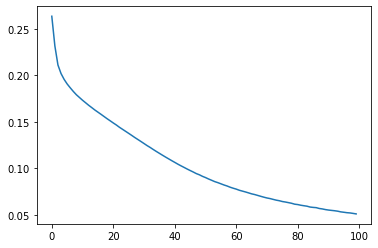

In [92]:
     pl.plot(history.history['loss'])

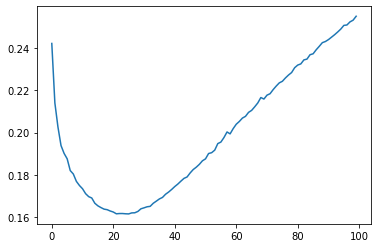

In [93]:
pl.plot(history.history['val_loss'])